### Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
import requests, os, sys
from io import StringIO
import pyspark
import math
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, \
                                      GBTClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
                                  MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, \
                                     MulticlassMetrics
from pyspark.sql.window import Window

from pyspark.sql.types import DoubleType

from pyspark.sql.types import *

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data

### Data

In [2]:
# connecting to spark
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [3]:
# call data and create dataframe
path = '../../data/external/BitcoinHeistData.csv'

raw_df = spark.read.csv(path, sep=',', inferSchema=True, header=True)

# rename label column
raw_df = raw_df.withColumnRenamed('label', 'ransomware')

# register table so we can use SQL
raw_df.registerTempTable('raw_df')

raw_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- looped: integer (nullable = true)
 |-- neighbors: integer (nullable = true)
 |-- income: decimal(14,0) (nullable = true)
 |-- ransomware: string (nullable = true)



### Label data

In [4]:
# make ransomware types into dataframe
ransomware_types = spark.sql(r"""SELECT distinct ransomware 
                                 FROM raw_df""")

# make ransomware types into a list
ransomware_list = [obj.ransomware for obj in ransomware_types.select("ransomware").collect()]

ransomware_list

['paduaJigsaw',
 'montrealXLockerv5.0',
 'montrealJigSaw',
 'montrealCryptoTorLocker2015',
 'montrealXTPLocker',
 'montrealAPT',
 'montrealRazy',
 'white',
 'montrealNoobCrypt',
 'princetonCerber',
 'montrealEDA2',
 'paduaCryptoWall',
 'montrealGlobeImposter',
 'montrealCryptConsole',
 'montrealSamSam',
 'montrealSam',
 'montrealDMALockerv3',
 'montrealXLocker',
 'montrealVenusLocker',
 'montrealCryptoLocker',
 'montrealGlobe',
 'montrealFlyper',
 'montrealDMALocker',
 'princetonLocky',
 'montrealCryptXXX',
 'paduaKeRanger',
 'montrealWannaCry',
 'montrealComradeCircle',
 'montrealGlobev3']

In [5]:
## SELECT RANSOMWARE TYPES FOR LABEL HERE
ransomware_label = [
                    'paduaJigsaw',
                    'montrealXLockerv5.0',
                    'montrealJigSaw',
                    'montrealCryptoTorLocker2015',
                    'montrealXTPLocker',
                    'montrealAPT',
                    'montrealRazy',
                    'montrealNoobCrypt',
                    'princetonCerber',
                    'montrealEDA2',
                    'paduaCryptoWall',
                    'montrealGlobeImposter',
                    'montrealCryptConsole',
                    'montrealSamSam',
                    'montrealSam',
                    'montrealDMALockerv3',
                    'montrealXLocker',
                    'montrealVenusLocker',
                    'montrealCryptoLocker',
                    'montrealGlobe',
                    'montrealFlyper',
                    'montrealDMALocker',
                    'princetonLocky',
                    'montrealCryptXXX',
                    'paduaKeRanger',
                    'montrealWannaCry',
                    'montrealComradeCircle',
                    'montrealGlobev3'
                   ]

# a function to add label to dataframe
def add_label(value):
    if value in ransomware_label:
        return 1
    else:
        return 0

In [6]:
# add label to dataframe
udfValueToLabel = udf(add_label, StringType())

df = raw_df.withColumn("label", udfValueToLabel("ransomware"))

# register table so we can use SQL
df.registerTempTable('df')

df.show(5)

+--------------------+----+---+------+-------------------+-----+------+---------+---------+---------------+-----+
|             address|year|day|length|             weight|count|looped|neighbors|   income|     ransomware|label|
+--------------------+----+---+------+-------------------+-----+------+---------+---------+---------------+-----+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|100050000|princetonCerber|    1|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|100000000| princetonLocky|    1|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|200000000|princetonCerber|    1|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2| 71200000|princetonCerber|    1|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|200000000| princetonLocky|    1|
+--------------------+----+---+------+-------------------+-----+------+---------+-------

### Splitting data

In [7]:
# the shape of the dataframe
df.count(), len(df.columns)

(2916697, 11)

In [8]:
# SET TEST SIZE HERE
test_size = 0.2
train_size = int(df.count()*(1-test_size))

# in the below code we order by date and add an id column

# split off unbalanced training data (we will balance this later)
unbalanced_train_df = spark.sql(f"""SELECT *
                                      FROM
                                      (SELECT ROW_NUMBER() OVER (ORDER BY year ASC, day ASC) AS pay_id, *
                                       FROM df)
                                      WHERE pay_id<={train_size}""")

# register table so we can use SQL
unbalanced_train_df.registerTempTable('unbalanced_train_df')

# split off test data (keep this unbalanced so it represents reality)
unbalanced_test_df = spark.sql(f"""SELECT *
                                  FROM
                                  (SELECT ROW_NUMBER() OVER (ORDER BY year ASC, day ASC) AS pay_id, *
                                   FROM df)
                                  WHERE pay_id>{train_size}""")

# register table so we can use SQL
unbalanced_test_df.registerTempTable('unbalanced_test_df')

### Balance training data
We want this to be 50/50

In [9]:
label_count = unbalanced_train_df.groupBy('label').count()
label_count.withColumn('percent', label_count['count']/unbalanced_train_df.count() * 100).show()

+-----+-------+------------------+
|label|  count|           percent|
+-----+-------+------------------+
|    0|2292932| 98.26751757232176|
|    1|  40425|1.7324824276782336|
+-----+-------+------------------+



In [10]:
# isolating rows with label=0 
white_train_df = unbalanced_train_df[unbalanced_train_df.label == 0]

# isolating rows with label=1
ransom_train_df = unbalanced_train_df[unbalanced_train_df.label == 1]

# register table so we can use SQL
ransom_train_df.registerTempTable('ransom_train_df')

# sample label=0 rows to equal label=1 rows
white_train_sample_size = ransom_train_df.count()
white_train_sample_pct = ransom_train_df.count()/white_train_df.count()
reduced_white_train_df = (white_train_df.sample(False, white_train_sample_pct*1.1, seed=4)
                                        .limit(white_train_sample_size))

# register table so we can use SQL
reduced_white_train_df.registerTempTable('reduced_white_train_df')

In [11]:
# concatenate to create balanced training data
train_df = spark.sql(r"""SELECT *
                          FROM ransom_train_df
                          UNION
                          SELECT *
                          FROM reduced_white_train_df
                          ORDER BY pay_id ASC""")

# register table so we can use SQL
train_df.registerTempTable('train_df')

In [12]:
label_count = train_df.groupBy('label').count()
label_count.withColumn('percent', label_count['count']/train_df.count() * 100).show()

+-----+-----+-------+
|label|count|percent|
+-----+-----+-------+
|    0|40425|   50.0|
|    1|40425|   50.0|
+-----+-----+-------+



### Balance testing data
We want this to be 98.58/1.42

In [13]:
label_count = unbalanced_test_df.groupBy('label').count()
label_count.withColumn('percent', label_count['count']/unbalanced_test_df.count() * 100).show()

+-----+------+------------------+
|label| count|           percent|
+-----+------+------------------+
|    0|582352| 99.83063050707992|
|    1|   988|0.1693694929200809|
+-----+------+------------------+



In [14]:
# isolating rows with label=0 
white_test_df = unbalanced_test_df[unbalanced_test_df.label == 0]

# isolating rows with label=1
ransom_test_df = unbalanced_test_df[unbalanced_test_df.label == 1]

# register table so we can use SQL
ransom_test_df.registerTempTable('ransom_test_df')

# sample label=0 rows to equal label=1 rows
white_test_sample_size = ransom_test_df.count()
white_test_sample_pct = ransom_test_df.count()/white_test_df.count()
reduced_white_test_df = (white_test_df.sample(False, white_test_sample_pct*70, seed=4))

# register table so we can use SQL
reduced_white_test_df.registerTempTable('reduced_white_test_df')

In [15]:
# concatenate to create balanced training data
test_df = spark.sql(r"""SELECT *
                          FROM ransom_test_df
                          UNION
                          SELECT *
                          FROM reduced_white_test_df
                          ORDER BY pay_id ASC""")

# register table so we can use SQL
test_df.registerTempTable('test_df')

In [16]:
label_count = test_df.groupBy('label').count()
label_count.withColumn('percent', label_count['count']/test_df.count() * 100).show()

+-----+-----+------------------+
|label|count|           percent|
+-----+-----+------------------+
|    0|68664| 98.58151955435595|
|    1|  988|1.4184804456440592|
+-----+-----+------------------+



### Vectorize

In [17]:
# the feature columns
features = train_df.schema.names[3:-2]

assembler = VectorAssembler(inputCols=features, outputCol='features')

train_pack = assembler.transform(train_df)
test_pack = assembler.transform(test_df)

columns_to_drop = train_df.schema.names[:-1]
for column in columns_to_drop:
    train_pack = train_pack.drop(column)
    test_pack = test_pack.drop(column)
    
train_pack.count(), test_pack.count()

(80850, 69652)

### Scale

In [18]:
minmaxscale = MinMaxScaler(inputCol='features', outputCol='features_scaled')
minmaxscale = minmaxscale.fit(train_pack)

train_pack = minmaxscale.transform(train_pack)
test_pack  = minmaxscale.transform(test_pack)

In [19]:
train_pack.show()

+-----+--------------------+--------------------+
|label|            features|     features_scaled|
+-----+--------------------+--------------------+
|    0|[1.0,2.0,0.25,1.0...|[0.0,0.0138888888...|
|    0|[1.0,18.0,9.76562...|[0.0,0.125,1.9598...|
|    0|[1.0,26.0,6.10351...|[0.0,0.1805555555...|
|    0|[1.0,22.0,2.44140...|[0.0,0.1527777777...|
|    0|[1.0,18.0,1.0,1.0...|[0.0,0.125,0.0020...|
|    0|[1.0,18.0,0.04057...|[0.0,0.125,8.1433...|
|    0|[1.0,24.0,1.0,1.0...|[0.0,0.1666666666...|
|    0|[1.0,74.0,1.0,1.0...|[0.0,0.5138888888...|
|    0|[1.0,30.0,1.52587...|[0.0,0.2083333333...|
|    0|[1.0,16.0,0.40577...|[0.0,0.1111111111...|
|    0|[1.0,12.0,0.00781...|[0.0,0.0833333333...|
|    0|[2.0,4.0,0.125,1....|[0.00274725274725...|
|    0|[2.0,0.0,1.0,1.0,...|[0.00274725274725...|
|    0|[2.0,2.0,0.25,1.0...|[0.00274725274725...|
|    0|[2.0,70.0,1.0,1.0...|[0.00274725274725...|
|    0|[2.0,118.0,1.0,1....|[0.00274725274725...|
|    0|[2.0,40.0,1.0,1.0...|[0.00274725274725...|


### Add polynomial features

In [20]:
# # adding polynomial features
# poly = PolynomialFeatures(degree=2) 


# # add degree two polynomials to budget
# X_budg = numpy.delete(poly.fit_transform(np.array(X_df[['budget']])), obj=0, axis=1) 
# X_budg_test = numpy.delete(poly.transform(np.array(X_test_df[['budget']])), obj=0, axis=1) 

### Make label double type

In [21]:
# had to run this line to avoid an illegal argument error, not entirely sure why...
train_pack = train_pack.withColumn("label", train_pack.label.cast(DoubleType()))
test_pack = test_pack.withColumn("label", test_pack.label.cast(DoubleType()))

# Modelling

## Gradient boosted trees

### Working model

In [22]:
gbt = GBTClassifier(maxDepth=3,
                    labelCol='label', 
                    featuresCol='features',
                    predictionCol='prediction')

gbt_model = gbt.fit(train_pack)
gbt_pred = gbt_model.transform(test_pack)

In [23]:
gbt_pred.show()

+-----+--------------------+--------------------+--------------------+--------------------+----------+
|label|            features|     features_scaled|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  0.0|[113.0,144.0,0.00...|[0.30769230769230...|[0.29455887802728...|[0.64316269237254...|       0.0|
|  0.0|[113.0,18.0,1.0,1...|[0.30769230769230...|[0.40042326804153...|[0.69015553427641...|       0.0|
|  0.0|[113.0,0.0,0.25,1...|[0.30769230769230...|[-0.0238244010916...|[0.48809005273920...|       1.0|
|  0.0|[113.0,144.0,3.17...|[0.30769230769230...|[0.31329208905559...|[0.65171453206048...|       0.0|
|  0.0|[113.0,6.0,1.0,1....|[0.30769230769230...|[-0.3010821584243...|[0.35384868842975...|       1.0|
|  0.0|[113.0,144.0,0.00...|[0.30769230769230...|[-0.1514405803337...|[0.42485331103443...|       1.0|
|  0.0|[113.0,0.0,0.25,1...|[0.30769230769230...|[-0.3948235752431...|[0.

In [24]:
metric = MulticlassMetrics(gbt_pred[['prediction', 'label']].rdd)

In [25]:
metric.confusionMatrix().toArray()

array([[33715., 34949.],
       [  577.,   411.]])

In [26]:
metric.fMeasure(1.0, 2.0)

0.052274114774114776

In [27]:
round(metric.recall(1.0), 2)

0.42

In [28]:
metric.accuracy

0.4899500373284328

### Playing with the beta parameter

In [29]:
betas = [1.0, 2.0, 4.0, 8.0]

### Tuning max depth

In [30]:
depths = [None, 2, 4, 6, 8]

In [31]:
# for depth in depths:
#     gbt = GBTClassifier(maxDepth=depth,
#                     labelCol='label', 
#                     featuresCol='features',
#                     predictionCol='prediction')

#     gbt_model = gbt.fit(train_pack)
#     gbt_pred = gbt_model.transform(test_pack)
    
#     metric = MulticlassMetrics(gbt_pred[['prediction', 'label']].rdd)
    
#     print(f'''Depth: {depth}, 
#               Accuracy: {round(metric.accuracy, 3)}, 
#               Recall: {round(metric.recall(1.0), 3)}, 
#               f_beta: {round(metric.fMeasure(1.0, 2.0), 2)}''')

Conclusion: model isnt very good but definitely worth having a max depth otherwise the model just fits to predict everything is non-ransomware

### Tuning step size

In [32]:
step_sizes = [0.001, 0.01, 0.1, 1.0]

In [33]:
# for step_size in step_sizes:
#     gbt = GBTClassifier(maxDepth=4,
#                         stepSize=step_size,
#                         labelCol='label', 
#                         featuresCol='features',
#                         predictionCol='prediction')

#     gbt_model = gbt.fit(train_pack)
#     gbt_pred = gbt_model.transform(test_pack)
    
#     metric = MulticlassMetrics(gbt_pred[['prediction', 'label']].rdd)
    
#     print(f'''Step size: {step_size}: 
#               Accuracy: {round(metric.accuracy, 3)}, 
#               Recall: {round(metric.recall(1.0), 3)}, 
#               f_beta: {round(metric.fMeasure(1.0, 2.0), 2)}''')

Conclusion: 

### Tuning max bins

In [34]:
bin_sizes = [4, 8, 16, 32, 64]

In [35]:
# for bin_size in bin_sizes:
#     gbt = GBTClassifier(maxDepth=4,
#                         maxBins=bin_size,
#                         labelCol='label', 
#                         featuresCol='features',
#                         predictionCol='prediction')

#     gbt_model = gbt.fit(train_pack)
#     gbt_pred = gbt_model.transform(test_pack)
    
#     metric = MulticlassMetrics(gbt_pred[['prediction', 'label']].rdd)
    
#     print(f'''Max bins: {bin_size}: 
#               Accuracy: {round(metric.accuracy, 3)}, 
#               Recall: {round(metric.recall(1.0), 3)}, 
#               f_beta: {round(metric.fMeasure(1.0, 2.0), 2)}''')

Conclusion:

### Tuning max iterations

In [36]:
iter_sizes = [4, 8, 16, 24, 32]

In [37]:
# for iter_size in iter_sizes:
#     gbt = GBTClassifier(maxDepth=4,
#                         maxIter=iter_size,
#                         labelCol='label', 
#                         featuresCol='features',
#                         predictionCol='prediction')

#     gbt_model = gbt.fit(train_pack)
#     gbt_pred = gbt_model.transform(test_pack)
    
#     metric = MulticlassMetrics(gbt_pred[['prediction', 'label']].rdd)
    
#     print(f'''Max iterations: {iter_size}: 
#               Accuracy: {round(metric.accuracy, 3)}, 
#               Recall: {round(metric.recall(1.0), 3)}, 
#               f_beta: {round(metric.fMeasure(1.0, 2.0), 2)}''')

Conclusion:

## Model building

In [40]:
# had to run this line to avoid an illegal argument error, not entirely sure why...
train_pack = train_pack.withColumn("label", train_pack.label.cast(DoubleType()))
test_pack = test_pack.withColumn("label", test_pack.label.cast(DoubleType()))

In [41]:
## THIS ONE TAKES SOME TIME
# logistic regression
lr = LogisticRegression(labelCol='label', 
                        featuresCol='features_scaled',
                        predictionCol='prediction')

lr_model = lr.fit(train_pack)
lr_pred = lr_model.transform(test_pack)


# Decision Tree (depth = 2)
dt = DecisionTreeClassifier(maxDepth=2, 
                            labelCol='label', 
                            featuresCol='features',
                            predictionCol='prediction')

dt_model = dt.fit(train_pack)
dt_pred = dt_model.transform(test_pack)


# Random Forest (depth = 2)
rf = RandomForestClassifier(maxDepth=2, 
                            labelCol='label',
                            featuresCol='features',
                            predictionCol='prediction')

rf_model = rf.fit(train_pack)
rf_pred = rf_model.transform(test_pack)


# Gradient Boosted Tree (depth = 2)
gbt = GBTClassifier(maxDepth=2, 
                    labelCol='label', 
                    featuresCol='features',
                    predictionCol='prediction')

gbt_model = gbt.fit(train_pack)
gbt_pred = gbt_model.transform(test_pack)


# Gradient Boosted Tree (depth = 2)
nb = NaiveBayes(labelCol='label', 
                    featuresCol='features',
                    predictionCol='prediction')

nb_model = nb.fit(train_pack)
nb_pred = nb_model.transform(test_pack)

## Model evaluation

In [42]:
accuracy = MulticlassClassificationEvaluator(labelCol='label', 
                                             predictionCol='prediction',
                                             metricName='accuracy')

precision = MulticlassClassificationEvaluator(labelCol='label', 
                                              predictionCol='prediction',
                                              metricName='weightedPrecision')

recall = MulticlassClassificationEvaluator(labelCol='label', 
                                           predictionCol='prediction',
                                           metricName='weightedRecall')

f1 = MulticlassClassificationEvaluator(labelCol='label', 
                                       predictionCol='prediction',
                                       metricName='f1')

areaROC = BinaryClassificationEvaluator(labelCol='label',
                                        rawPredictionCol='prediction',
                                        metricName='areaUnderROC')

In [43]:
# # CANT GET BETA PARAMETER TO WORK
# f_beta = MulticlassClassificationEvaluator(labelCol='label', 
#                                        predictionCol='prediction',
#                                        metricName='fMeasureByLabel')

In [44]:
# the error metrics
metrics = [accuracy, precision, recall, f1, areaROC]
metric_labels = ['accuracy', 'precision', 'recall', 'f1', 'areaROC']

# the predictions from each model
predictions = [lr_pred, dt_pred, rf_pred, gbt_pred, nb_pred]
predict_labels = ['LR', 'DT', 'RF', 'GBT', 'NB']

In [45]:
# eval_list = list()

# # for each model's predictions, calculate error metrics
# # and add to a Pandas series
# for pred in zip(predict_labels, predictions):
#     name = pred[0]
#     predict = pred[1]
    
#     metric_vals = pd.Series(dict([(x[0], x[1].evaluate(predict)) 
#                                  for x in zip(metric_labels, metrics)]),
#                             name=name)
#     eval_list.append(metric_vals)
    
# # combine all the series into a dataframe
# eval_df = pd.concat(eval_list, axis=1).T
# eval_df = eval_df[metric_labels]
# eval_df

## Model evaluation function

In [46]:
def evaluate_model_predictions(prediction_list, prediction_labels):
    
    eval_list = list()

    # for each model's predictions, calculate error metrics
    # and add to a Pandas series
    for pred in zip(prediction_labels, prediction_list):
        name = pred[0]
        predict = pred[1]

        # here is where the prediction dataframe is converted to an rdd
        predict_rdd = predict[['prediction', 'label']].rdd
        b_metrics = BinaryClassificationMetrics(predict_rdd)
        m_metrics = MulticlassMetrics(predict_rdd)

        metric_vals = pd.Series({'accuracy'        : m_metrics.accuracy,
                                 'precision'       : m_metrics.precision(0),
                                 'recall'          : m_metrics.recall(0),
                                 'f1'              : m_metrics.fMeasure(),
                                 'areaROC'         : b_metrics.areaUnderROC,
                                 'confusion matrix': (m_metrics.confusionMatrix()
                                                      .toArray().astype('int'))},
                                name=name)
        eval_list.append(metric_vals)

    # combine all the series into a dataframe
    eval_df = pd.concat(eval_list, axis=1).T
    
    metric_labels = ['accuracy', 'precision', 'recall', 'f1', 'areaROC', 'confusion matrix']
    eval_df = eval_df[metric_labels]
    
    return eval_df

## Make a pipeline

In [47]:
## NEED TO THINK ABOUT THE VALUE OF THIS, HOW IT WORKS AND HOW WE SHOULD CHANGE ALL OUR CODE TO USE IT EFFECTIVELY

# # the pipline
# pipeline = Pipeline(stages=[assembler, minmaxscale, lr]) 

# # fit and transform
# lr_model2 = pipeline.fit(train_pack)
# lr_pred2 = lr_model2.transform(test_pack)

# # the results are the same for GBT as the second table above
# evaluate_model_predictions([lr_pred2], ['LR'])

## Cross validation and grid search

In [48]:
# the GradientBoostedTree model
gbt2 = GBTClassifier(featuresCol='features',
                     labelCol='label', 
                     predictionCol='prediction')
 
# the pipline
pipeline = Pipeline(stages=[gbt2]) 

# the parameter grid--we'll optimize maxDepth and stepSize
paramgrid = (ParamGridBuilder().addGrid(gbt2.maxDepth, [4,6])
                               .addGrid(gbt2.stepSize, [0.001, 0.01, 0.1, 1.0]).build())

# use f1 score as the evaluation metric for best model 
evaluator = MulticlassClassificationEvaluator(labelCol='label', 
                                              predictionCol='prediction', 
                                              metricName='f1') 

# use 3-fold cross validation 
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramgrid, 
                          evaluator=evaluator, 
                          numFolds=3) 

gbt2_model = crossval.fit(train_pack) 

In [49]:
# return the best pipeline based on f1 score
best_pipeline = gbt2_model.bestModel

# return the best GBT model, which is the first step of the pipeline
best_gbt_model = best_pipeline.stages[0]


In [50]:
# how many trees were there?
len(best_gbt_model.trees)


20

In [51]:
# list some of the trees
best_gbt_model.trees[:5]


[DecisionTreeRegressionModel (uid=dtr_a625b23fdff7) of depth 6 with 127 nodes,
 DecisionTreeRegressionModel (uid=dtr_fc409a6ef577) of depth 6 with 127 nodes,
 DecisionTreeRegressionModel (uid=dtr_2d2cf35bf939) of depth 6 with 127 nodes,
 DecisionTreeRegressionModel (uid=dtr_08dace01da3c) of depth 6 with 125 nodes,
 DecisionTreeRegressionModel (uid=dtr_5209af544ea7) of depth 6 with 127 nodes]

In [52]:
# what were their weights in the GBT model?
best_gbt_model.treeWeights[:5]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [53]:
# what was the best depth?
[x.depth for x in best_gbt_model.trees]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [54]:
# extract feature importances
feature_importances = best_gbt_model.featureImportances.toArray()

# extract feature names, except for the predictor
feature_names = features

feature_series = (pd.Series(dict(zip(feature_names, feature_importances)))
                  .sort_values(ascending=True))

feature_series

looped       0.040669
count        0.086100
length       0.092691
neighbors    0.112710
weight       0.124369
day          0.253003
income       0.290458
dtype: float64

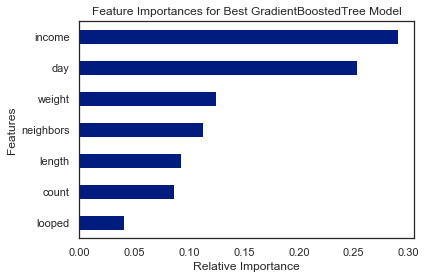

In [55]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

ax = feature_series.plot(kind='barh')
_ = ax.set(xlabel='Relative Importance', 
           ylabel='Features', 
           title='Feature Importances for Best GradientBoostedTree Model')

fig = plt.gcf()

# save to the folder shared with the AWS instance
# this is the same folder as the notebook is executed from
# so a path is not required
# fig.savefig('img/feature_importances.pdf')

## Measure against test data

### Initial evaluation

In [56]:
gbt_pred_test = best_pipeline.transform(test_pack)

In [57]:
evaluate_model_predictions([gbt_pred_test], ['GBT_GridSearch'])

,accuracy,precision,recall,f1,areaROC,confusion matrix
GBT_GridSearch,0.667432,0.986173,0.67207,0.667432,0.508606,"[[46147, 22517], [647, 341]]"


In [58]:
metric = MulticlassMetrics(gbt_pred_test[['prediction', 'label']].rdd)

In [59]:
metric.confusionMatrix().toArray()

array([[46147., 22517.],
       [  647.,   341.]])

In [60]:
metric.fMeasure(1.0, 1.0)

0.02860018451731947

In [61]:
metric.recall(1.0)

0.3451417004048583

In [62]:
metric.precision(1.0)

0.014918190567853706

In [63]:
metric.accuracy

0.6674323781083099